In [ ]:
!pip install zipfile-deflate64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00


In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
!PYTHONHASHSEED=0

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from matplotlib import pyplot as plt
import copy
import math
import matplotlib
import zipfile_deflate64 as zipfile
from shutil import copyfile
from time import time
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import random
import cv2
import shutil
import os
import gc
import glob
import json
import ast
from google.colab import drive

print(keras.__version__)
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

2.12.0


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#configuring the path of kaggle file .json type
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d qingyi/wm811k-wafer-map

 98% 147M/149M [00:01<00:00, 116MB/s]
100% 149M/149M [00:01<00:00, 98.7MB/s]


In [ ]:
# extracting the dataset from its compressed format
from zipfile import ZipFile
dataset='/content/wm811k-wafer-map.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("The dataset is extracted")


The dataset is extracted


In [ ]:
data = pd.read_pickle('LSWMD.pkl')

In [ ]:
data.shape

(811457, 6)

In [ ]:
data.head(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
data['failureType'].map(lambda x: list(x)!=[]).sum()

172950

In the context of the paper by Wu, Jang, and Chen titled "**Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets**" the dataset they worked with, known as "**wm-811k**," consists of a total of *811,457* data points. However, only a subset of *172,950* data points has been labeled, making them suitable for training the neural network. The remaining data points are unlabelled and have been excluded from the training process.

The decision to eliminate the unlabelled data points might stem from the fact that labeled data is essential for supervised learning, which is a common approach when training neural networks. By using the labeled subset for training, the researchers likely aimed to develop a model capable of recognizing patterns and similarities within the wafer map data that correspond to known failure instances.

In [ ]:
data_unlabelled = pd.DataFrame()
data_unlabelled = data[data['failureType'].map(lambda x: list(x)==[])]
data_unlabelled.shape

(638507, 6)

In [ ]:
data_unlabelled.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
35,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,11.0,[],[]
45,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,21.0,[],[]
69,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot3,20.0,[],[]
120,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot5,21.0,[],[]
158,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2,...",533.0,lot7,9.0,[],[]


In [ ]:
data_labelled = pd.DataFrame()
data_labelled = data[data['failureType'].map(lambda x: list(x)!=[])]
data_labelled.shape

(172950, 6)

In [ ]:
data_labelled.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
data_labelled['failureType'] = data_labelled['failureType'].map(lambda x: x[0][0])
data_labelled['trianTestLabel'] = data_labelled['trianTestLabel'].map(lambda x: x[0][0])
data_labelled.rename(columns = {'trianTestLabel':'trainTestLabel'}, inplace = True)

In [ ]:
data_labelled.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none


<h2> Data analysis </h2>
Let's analyze different aspects of the dataset. In particular, we focus on critical aspects such as the imbalance between classes, the presence of defective images and the different forms assumed by the images.

In [ ]:
number_labelled_data = data_labelled.shape[0]

In [ ]:
failure_types = list(pd.unique(data_labelled['failureType']))
failure_types

['none',
 'Loc',
 'Edge-Loc',
 'Center',
 'Edge-Ring',
 'Scratch',
 'Random',
 'Near-full',
 'Donut']

In [ ]:
types_image_number = list(map(lambda x: (data_labelled['failureType']==x).sum(), failure_types))
types_image_number

[147431, 3593, 5189, 4294, 9680, 1193, 866, 149, 555]

In [ ]:
types_image_proportion = list(map(lambda x: round(x/number_labelled_data,3), types_image_number))
types_image_proportion

[0.852, 0.021, 0.03, 0.025, 0.056, 0.007, 0.005, 0.001, 0.003]

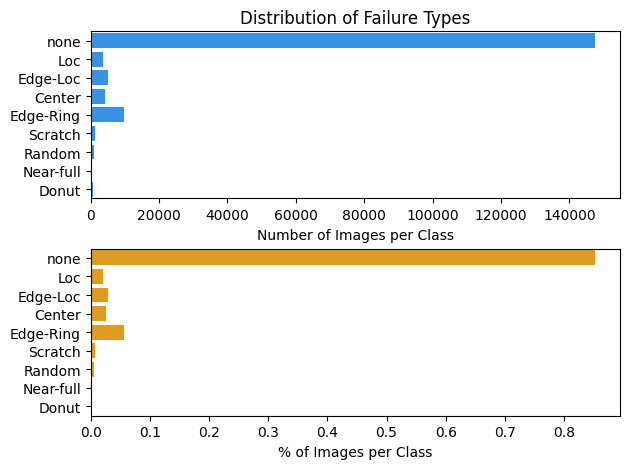

In [ ]:
import seaborn as sns
# Subplot 1: Number of Images per Class
plt.subplot(2, 1, 1)
sns.barplot(x=types_image_number, y=failure_types, color='dodgerblue')
plt.xlabel('Number of Images per Class')
plt.ylabel('')
plt.title('Distribution of Failure Types')

# Subplot 2: Percentage of Images per Class
plt.subplot(2, 1, 2)
sns.barplot(x=types_image_proportion, y=failure_types, color='orange')
plt.xlabel('% of Images per Class')
plt.ylabel('')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Adjust spacing between subplots
plt.show()

In [ ]:
number_failure_images = sum(types_image_number[1:])
number_ok_images = types_image_number[0]
[number_failure_images,number_ok_images]

[25519, 147431]

In [ ]:
import plotly.express as px
data = {'Image Category': ['With Failure', 'None'],
        'Number of Images': [number_failure_images, number_ok_images]}

fig = px.bar(data, x='Image Category', y='Number of Images', color='Image Category',
             labels={'Number of Images': 'Number of Images'},
             title='Distribution of Images')

fig.update_layout(showlegend=False,width=600, height=400)
fig.show()

The dataset is strongly biased towards the none class, that is the one without defects. We will definitely need to do **data augmentation**.


In [ ]:
data = {'Failure Type': failure_types,
        'Images per Class': types_image_number}

fig = px.bar(data, y='Failure Type', x='Images per Class', orientation='h',
             labels={'Images per Class': 'Images per class', 'Failure Type': 'Failure Type'},
             title='Images per Class for Different Failure Types',
             text='Images per Class',  # Use text parameter for annotations
             color='Failure Type', color_discrete_sequence=px.colors.qualitative.Pastel)

# Add annotations (count) to the bars
fig.update_traces(texttemplate='%{text}', textposition='inside', insidetextanchor='middle')

fig.update_layout(legend_title_text='Failure Types')  # Customize the legend title

fig.show()

Text(0.5, 0, 'Images per class')

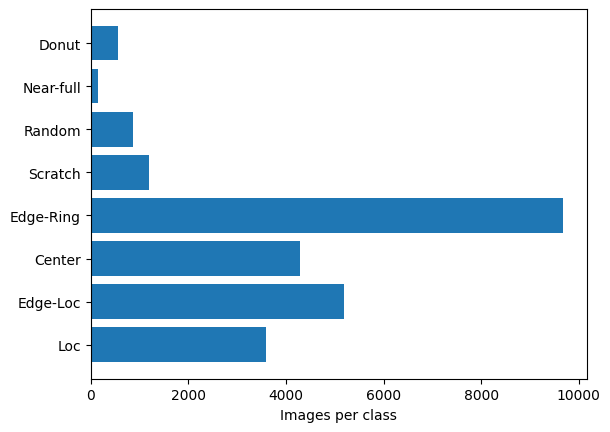

In [ ]:
plt.barh(failure_types[1:], types_image_number[1:])
plt.xlabel('Images per class')

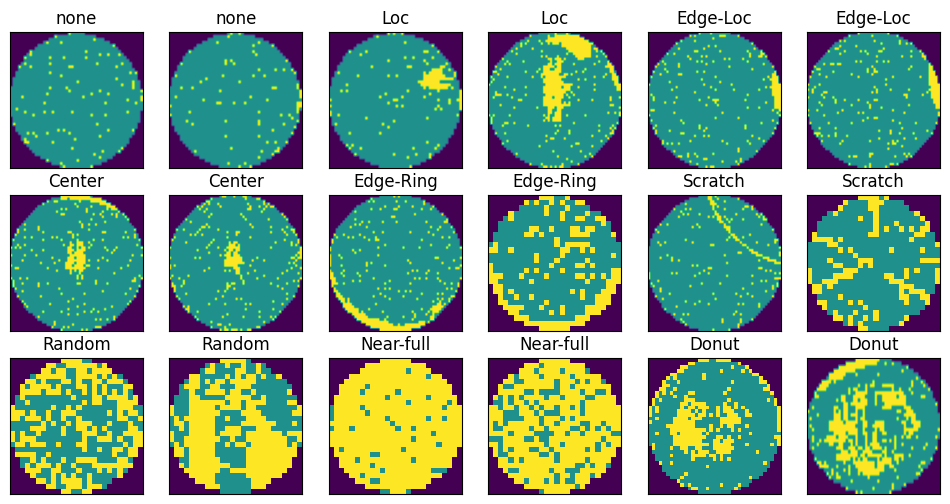

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

fig = plt.figure(figsize=(12, 6))
grid = gridspec.GridSpec(3, 6, wspace=0.2, hspace=0.2)

for i, failure_type in enumerate(failure_types):
    indices = data_labelled['failureType'] == failure_type
    for j in range(2):  # Display up to 2 images for each failure type
        ax = plt.subplot(grid[2*i + j])

        if indices.sum() > j:
            image = Image.fromarray(data_labelled['waferMap'][indices].iloc[j])
            ax.imshow(image, aspect='auto')
            ax.set_title(failure_type)
        else:
            ax.set_visible(False)  # Hide empty subplots

        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show();

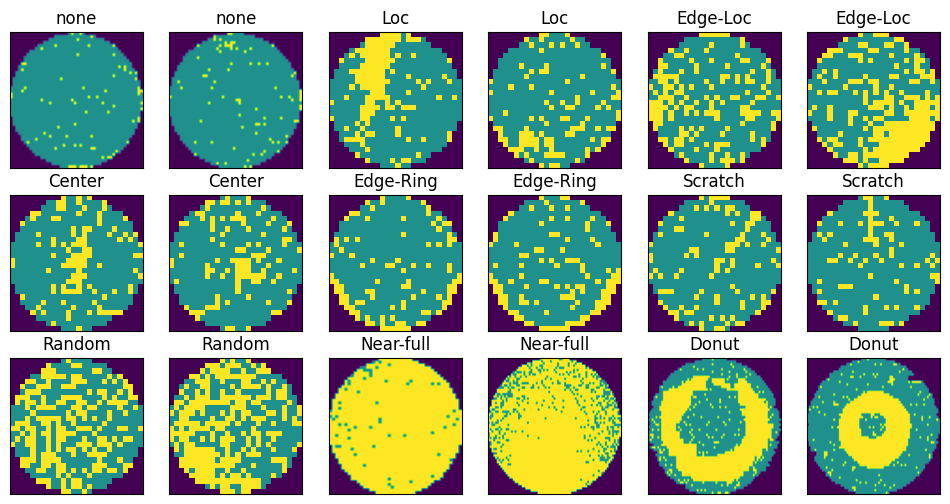

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

fig = plt.figure(figsize=(12, 6))
grid = gridspec.GridSpec(3, 6, wspace=0.2, hspace=0.2)

for i in range(len(failure_types)):
    b = 0
    for j in [0, 1]:
        if i != 0:
            b = 1
        ax = plt.subplot(grid[2*i + j])

        if i < len(data_labelled['failureType']):
            image = Image.fromarray(data_labelled['waferMap'][data_labelled['failureType'] == failure_types[i]].iloc[j + 10])
            ax.imshow(image, aspect='auto')
            ax.set_title(failure_types[i])
        else:
            ax.set_visible(False)  # Hide empty subplots

        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


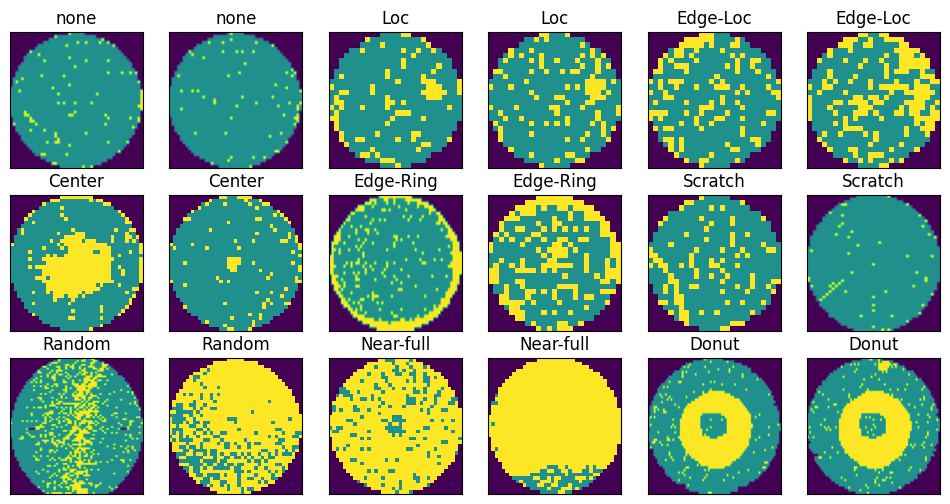

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

fig = plt.figure(figsize=(12, 6))
grid = gridspec.GridSpec(3, 6, wspace=0.2, hspace=0.2)

for i, failure_type in enumerate(failure_types):
    indices = data_labelled['failureType'] == failure_type
    for j in range(2):  # Display up to 2 images for each failure type
        ax = plt.subplot(grid[2*i + j])

        if i != 0:
            b = 1
        else:
            b = 0

        if indices.sum() > j + 20:
            image = Image.fromarray(data_labelled['waferMap'][indices].iloc[j + 20])
            ax.imshow(image, aspect='auto')
            ax.set_title(failure_type)
        else:
            ax.set_visible(False)  # Hide empty subplots

        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

--------------------------------------------

As previously highlighted, it's important to address the variability in image shapes within the dataset before proceeding to utilize them for training a neural network. Since neural networks typically expect input data to have consistent dimensions, the presence of images with differing shapes necessitates a preprocessing step involving resizing. By doing so, all images can be brought to a uniform size, ensuring compatibility with the neural network architecture.

-------------------------------------------

To delve deeper into this issue, a thorough examination of the dataset is warranted to identify images with problematic shapes. Through meticulous analysis, we can isolate instances where image dimensions diverge from the norm. This granular evaluation is pivotal for pinpointing which specific images require resizing to conform to the neural network's input specifications.

--------------------------------------------

By conducting this shape analysis, we can not only identify the scope of the issue but also devise an appropriate strategy for image resizing. The process may involve techniques such as interpolation to maintain image quality, while striving to preserve essential features for accurate pattern recognition. Consequently, we can mitigate the challenges posed by disparate image shapes and pave the way for effective training and utilization of the neural network.

---------------------------------------------

In [ ]:
shapes = pd.unique(data_labelled['waferMap'].map(lambda x: x.shape))
shapes.shape

(346,)

In [ ]:
data_labelled['waferMap'].shape

(172950,)

In [ ]:
shapes_sorted_first_dimension = sorted(shapes)
shapes_sorted_second_dimension = sorted(shapes, key=lambda x: x[1])
shapes_sorted_product_dimension = sorted(shapes, key=lambda x: x[0]*x[1])

In [ ]:
print(shapes_sorted_first_dimension[:5])
print('------------------------------------------------')
print(shapes_sorted_second_dimension[:5])
print('------------------------------------------------')
print(shapes_sorted_product_dimension[:5])

[(15, 3), (18, 4), (18, 44), (22, 35), (22, 50)]
------------------------------------------------
[(15, 3), (18, 4), (24, 13), (27, 15), (40, 18)]
------------------------------------------------
[(15, 3), (18, 4), (24, 13), (27, 15), (24, 18)]


In [ ]:
data_labelled['shape'] = data_labelled['waferMap'].map(lambda x: x.shape)
data_labelled.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,shape
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"


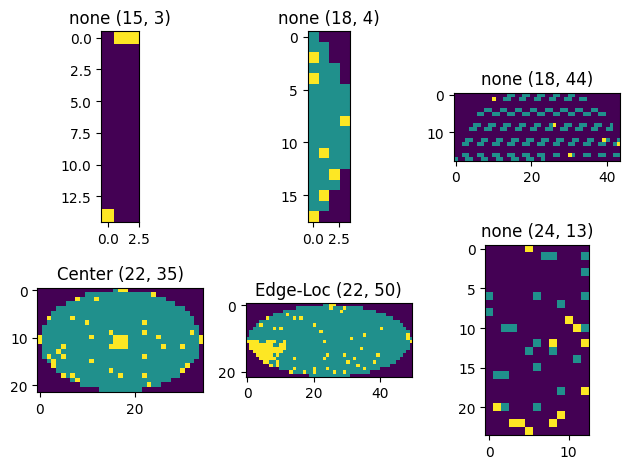

In [ ]:
fig = plt.figure()

for i in range(len(shapes_sorted_first_dimension[:6])):
  data = data_labelled[data_labelled['shape'] == shapes_sorted_first_dimension[i]]
  fig.add_subplot(2,3,i+1)
  plt.imshow(data['waferMap'].iloc[0])
  plt.title(data['failureType'].iloc[0]+' '+str(data['shape'].iloc[0]))

plt.tight_layout()

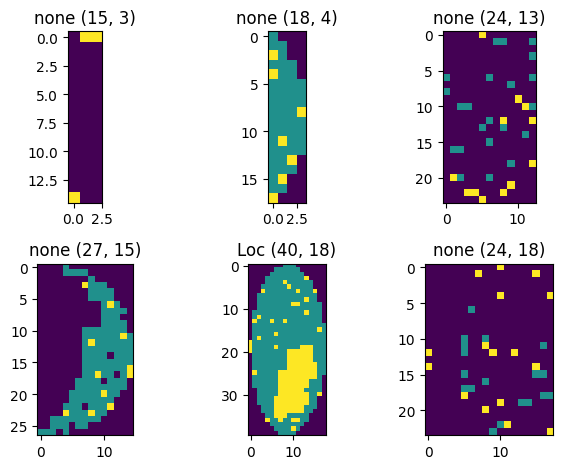

In [ ]:
fig = plt.figure()

for i in range(len(shapes_sorted_second_dimension[:6])):
  data = data_labelled[data_labelled['shape'] == shapes_sorted_second_dimension[i]]
  fig.add_subplot(2,3,i+1)
  plt.imshow(data['waferMap'].iloc[0])
  plt.title(data['failureType'].iloc[0]+' '+str(data['shape'].iloc[0]))

plt.tight_layout()

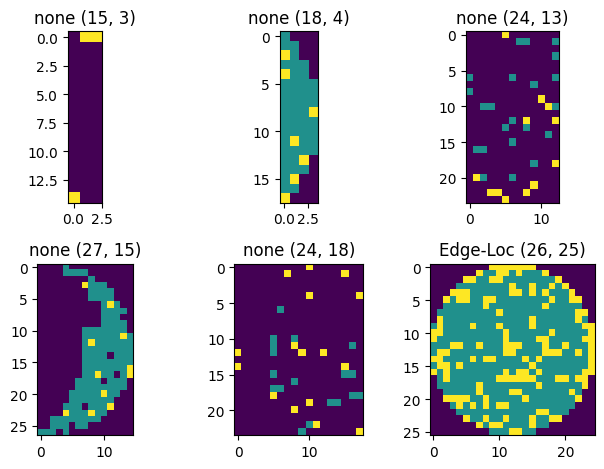

In [ ]:
fig = plt.figure()

for i in range(len(shapes_sorted_second_dimension[:6])):
  data = data_labelled[data_labelled['shape'] == shapes_sorted_product_dimension[i]]
  fig.add_subplot(2,3,i+1)
  plt.imshow(data['waferMap'].iloc[0])
  plt.title(data['failureType'].iloc[0]+' '+str(data['shape'].iloc[0]))

plt.tight_layout()

The pictures we looked at earlier gave us some important information. It seems that some pictures labeled as "none" don't actually show semiconductor wafers. These pictures show shapes that don't match what we expect from those wafers.

-------------------------------------------
Additionally, we noticed that some pictures are much bigger or smaller than usual. This could be because something went wrong when taking these pictures, like the camera didn't work properly.

-------------------------------------------

Because of these issues, we need to be careful when using these pictures to teach a computer program. If we use them without fixing the problems, the program might get confused and make mistakes.

In [ ]:
# The first element of the tuple is the shape
# The second element of the tuple is the numerosity
shape_image_number = list()
for shape in shapes:
  shape_image_number.append(
      (shape,np.sum([data_labelled['shape']==shape]))
  )

shape_image_number

[((45, 48), 103),
 ((53, 58), 136),
 ((26, 26), 14366),
 ((70, 58), 24),
 ((60, 40), 25),
 ((37, 37), 376),
 ((37, 55), 25),
 ((41, 57), 24),
 ((39, 39), 30),
 ((62, 75), 118),
 ((50, 43), 423),
 ((43, 43), 36),
 ((36, 34), 139),
 ((42, 43), 447),
 ((75, 63), 23),
 ((32, 36), 3),
 ((102, 66), 17),
 ((54, 71), 206),
 ((29, 29), 17),
 ((38, 45), 1),
 ((41, 41), 1463),
 ((118, 84), 8),
 ((54, 42), 11),
 ((42, 29), 5),
 ((49, 39), 166),
 ((35, 38), 6),
 ((41, 56), 2),
 ((43, 42), 1267),
 ((26, 25), 7),
 ((30, 30), 60),
 ((33, 29), 8125),
 ((34, 34), 708),
 ((52, 55), 100),
 ((35, 31), 4331),
 ((30, 34), 12400),
 ((50, 39), 7),
 ((33, 33), 231),
 ((32, 29), 413),
 ((63, 62), 1424),
 ((34, 35), 15),
 ((39, 31), 454),
 ((38, 36), 2127),
 ((69, 73), 484),
 ((25, 27), 18781),
 ((113, 71), 6),
 ((26, 30), 1513),
 ((29, 30), 9),
 ((40, 40), 242),
 ((87, 89), 5),
 ((70, 36), 2),
 ((56, 41), 235),
 ((89, 76), 29),
 ((52, 59), 186),
 ((33, 24), 22),
 ((36, 36), 29),
 ((45, 46), 8),
 ((76, 64), 2),
 

The **first element** of the tuple is the shape of an image. This shape is described using two numbers, which likely represent the height and width of the image in terms of pixels.

The **second element** of the tuple is the numerosity, which indicates how many images have that particular shape.

In [ ]:
mean_first_dimension =  np.mean(list(map(lambda x: x[0][0], shape_image_number)))
mean_second_dimension = np.mean(list(map(lambda x: x[0][1], shape_image_number)))
print('Mean First Dimension',' ', 'Mean Second Dimension')
print(mean_first_dimension,'     ', mean_second_dimension)

Mean First Dimension   Mean Second Dimension
57.73699421965318       57.26589595375722


In [ ]:
median_first_dimension =  np.median(list(map(lambda x: x[0][0], shape_image_number)))
median_second_dimension = np.median(list(map(lambda x: x[0][1], shape_image_number)))
print('median first dim.', 'median second dim.')
print(median_first_dimension, '            ', median_second_dimension)

median first dim. median second dim.
53.0              52.0


In [ ]:
median_shape = (int(median_first_dimension), int(median_second_dimension))
list(filter(lambda x: x[0]==median_shape, shape_image_number))

[((53, 52), 1519)]

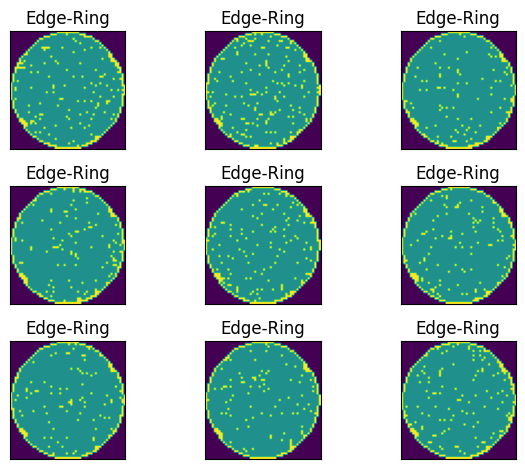

In [ ]:
median_images = data_labelled[data_labelled['shape']==median_shape]
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(median_images['waferMap'].iloc[i])
  plt.xticks([])
  plt.yticks([])
  plt.title(median_images['failureType'].iloc[i])

plt.tight_layout()

In [ ]:
ratio = 1.5
very_rectangular_shapes = list(filter(lambda x: (x[0][0]/x[0][1]>1.5) or (x[0][1]/x[0][0]>1.5), shape_image_number))
len(very_rectangular_shapes)

26

In [ ]:
number_rectangular_per_class = list()

for type_ in failure_types:
  filter1 = data_labelled['failureType'] == type_
  data = data_labelled[filter1]
  counter = 0
  for shape in very_rectangular_shapes:
    print(type_, shape)
    filter2 = data_labelled['shape'] == shape[0]
    counter += len(data[filter2])

  number_rectangular_per_class.append((type_, counter))

none ((102, 66), 17)
none ((113, 71), 6)
none ((70, 36), 2)
none ((51, 30), 1526)
none ((72, 43), 2)
none ((29, 45), 1)
none ((22, 35), 2)
none ((212, 84), 8)
none ((26, 50), 1)
none ((40, 18), 3)
none ((43, 133), 1)
none ((38, 62), 1)
none ((122, 204), 3)
none ((101, 65), 123)
none ((98, 64), 9)
none ((75, 48), 3)
none ((22, 50), 899)
none ((72, 44), 45)
none ((63, 160), 11)
none ((131, 66), 3)
none ((88, 56), 11)
none ((24, 13), 1)
none ((18, 4), 1)
none ((15, 3), 1)
none ((27, 15), 1)
none ((18, 44), 1)
Loc ((102, 66), 17)
Loc ((113, 71), 6)
Loc ((70, 36), 2)
Loc ((51, 30), 1526)
Loc ((72, 43), 2)
Loc ((29, 45), 1)
Loc ((22, 35), 2)
Loc ((212, 84), 8)
Loc ((26, 50), 1)
Loc ((40, 18), 3)
Loc ((43, 133), 1)
Loc ((38, 62), 1)
Loc ((122, 204), 3)
Loc ((101, 65), 123)
Loc ((98, 64), 9)
Loc ((75, 48), 3)
Loc ((22, 50), 899)
Loc ((72, 44), 45)
Loc ((63, 160), 11)
Loc ((131, 66), 3)
Loc ((88, 56), 11)
Loc ((24, 13), 1)
Loc ((18, 4), 1)
Loc ((15, 3), 1)
Loc ((27, 15), 1)
Loc ((18, 44), 1)
Ed

In [ ]:
#The tuple indicates, for each class, how many images have a strongly rectangular shape.
number_rectangular_per_class

[('none', 2381),
 ('Loc', 79),
 ('Edge-Loc', 147),
 ('Center', 15),
 ('Edge-Ring', 20),
 ('Scratch', 34),
 ('Random', 6),
 ('Near-full', 0),
 ('Donut', 0)]

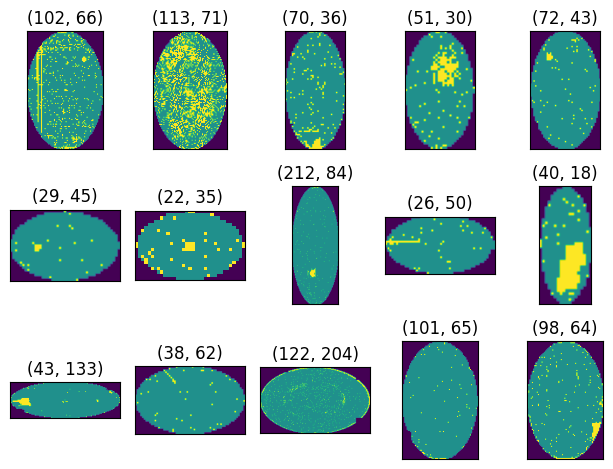

In [ ]:
#Most of the images belong to the **none** class, which we know to be much more numerous than the others.
for i in range(15):
  plt.subplot(3,5,i+1)
  filter = data_labelled['shape']==very_rectangular_shapes[i][0]
  im = data_labelled[filter]['waferMap'].iloc[0]
  plt.imshow(im)
  plt.xticks([])
  plt.yticks([])
  plt.title(data_labelled[filter]['shape'].iloc[0])

plt.tight_layout()

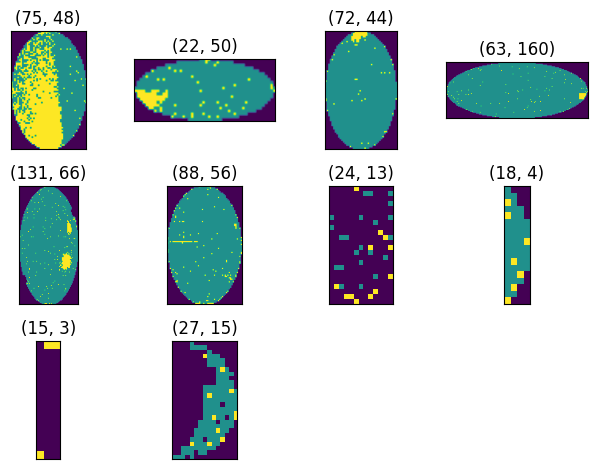

In [ ]:
for i in range(15,25):
  plt.subplot(3,4,i+1-15)
  filter = data_labelled['shape']==very_rectangular_shapes[i][0]
  im = data_labelled[filter]['waferMap'].iloc[0]
  plt.imshow(im)
  plt.xticks([])
  plt.yticks([])
  plt.title(data_labelled[filter]['shape'].iloc[0])

plt.tight_layout()


We observe that some images with rectangular shape are also defective.

# Data cleaning

In [ ]:
print(len(data_labelled))
data_labelled = data_labelled.reset_index(drop = True)

for shape in very_rectangular_shapes:
  data_labelled = data_labelled[data_labelled['shape'] != shape[0]]

print(len(data_labelled))

172950
170268


In [ ]:
data_labelled = data_labelled.reset_index(drop = True)
data_labelled.tail()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,shape
170263,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc,"(26, 30)"
170264,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc,"(26, 30)"
170265,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)"
170266,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)"
170267,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring,"(26, 30)"


In [ ]:
shapes = pd.unique(data_labelled['waferMap'].map(lambda x: x.shape))
shapes.shape

(320,)

In [ ]:
shape_image_number = list()
for shape in shapes:
  shape_image_number.append(
      (shape,np.sum([data_labelled['shape']==shape]))
  )

In [ ]:
count_pixel = [0]*320
for i in range(len(shapes)):

  area = np.product(shapes[i])
  filtered_data = data_labelled[data_labelled['shape']==shapes[i]]
  count1 = sum(list(map(lambda x: list(x.reshape(area)).count(1),filtered_data['waferMap'])))
  count2 = sum(list(map(lambda x: list(x.reshape(area)).count(2),filtered_data['waferMap'])))
  total_pixel_no_background = count1 + count2
  total_area = shape_image_number[i][1]*area
  if (i%50==0):
    print(area, total_pixel_no_background, total_area)
  count_pixel[i] = total_pixel_no_background/total_area


2160 173352 222480
792 13354 17424
1024 622911 804864
1980 214524 277200
1722 32712 41328
4761 22584 28566
2597 3970 5194


In [ ]:
count_pixel[:10]

[0.7791801510248112,
 0.8002602472348731,
 0.7884401203696763,
 0.8123152709359606,
 0.815,
 0.7962832009698024,
 0.7960687960687961,
 0.7753530166880617,
 0.7740959894806049,
 0.7963440860215054]

In [ ]:
print('id',' shape','   mean')
for i in range(len(count_pixel)):
  if(count_pixel[i] < 0.7):
    print(i,shapes[i],count_pixel[i])

id  shape    mean
179 (84, 74) 0.1751930501930502
309 (24, 18) 0.0787037037037037
310 (53, 71) 0.6736646292851448


Let's save the indices of the defective images for each shape, i.e. with very low non-background pixel ratio (less than 0.6).

In [ ]:
defect = []
defect2 = []

for i in range(len(data_labelled)):
  if(i%10000==0):
    print(i)
  area = np.product(data_labelled['shape'].iloc[i])
  count1 = list(data_labelled['waferMap'].iloc[i].reshape(area)).count(1)
  count2 = list(data_labelled['waferMap'].iloc[i].reshape(area)).count(2)
  pixel_no_background = count1 + count2
  proportion = pixel_no_background/area
  if(proportion < 0.6):
    defect.append(i)
  if(0.6 <= proportion <= 0.7 ):
    defect2.append(i)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000


In [ ]:
defect[:10]

[16176, 16177, 16178, 16179, 16180, 16181, 16182, 16183, 16184, 16185]

In [ ]:
print(len(defect))

22


We display the defective images (proportion < 0.6).

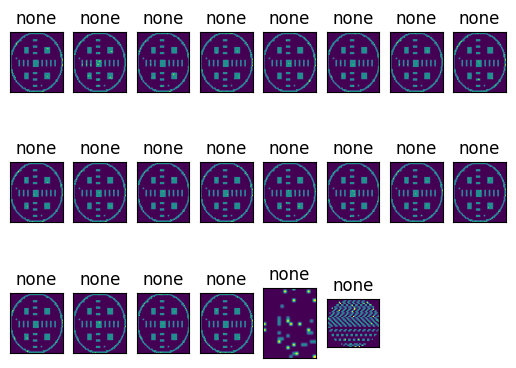

In [ ]:
for i in range(len(defect)):
  plt.subplot(3,8,i+1)
  plt.imshow(data_labelled['waferMap'].iloc[defect[i]])
  plt.xticks([])
  plt.yticks([])
  plt.title(data_labelled['failureType'].iloc[defect[i]])

Instead, we observe that for images with a proportion greater than 0.6 the shape of the wafer is well identifiable.

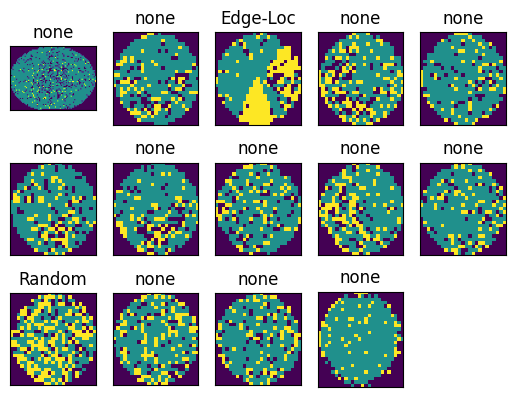

In [ ]:
for i in range(len(defect2)):
  plt.subplot(3,5,i+1)
  plt.imshow(data_labelled['waferMap'].iloc[defect2[i]])
  plt.xticks([])
  plt.yticks([])
  plt.title(data_labelled['failureType'].iloc[defect2[i]])

There are 22 defective images. We save the indexes.

In [ ]:
dict_ = {'Indici': defect}
df = pd.DataFrame(dict_)
df.to_csv('/content/Indici_immagini_difettose.csv')

In [ ]:
to_delete = pd.read_csv("/content/Indici_immagini_difettose.csv")

for el in to_delete['Indici']:
  data_labelled.drop(el, axis = 0, inplace = True)
data_labelled = data_labelled.reset_index(drop = True)
data_labelled.tail()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,shape
170241,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc,"(26, 30)"
170242,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc,"(26, 30)"
170243,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)"
170244,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)"
170245,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring,"(26, 30)"


Now we have the dataset cleansed of flawed and unbalanced images. Let's save it.

In [ ]:
result = data_labelled.to_json(orient = "split")
parsed = json.loads(result)

with open('/content/WM811K_clean.json', 'w') as f:
    json.dump(parsed, f)

## Data Preprocessing and Splitting

Once we have cleaned the dataset of defective images, we can work with the remaining **170,246** images. First of all, we eliminate the useless columns, namely `dieSize`, `lotName`, `waferIndex`, `trainTestLabel`, and `shape`.

The two remaining columns represent the image pixels and the type of anomaly, with nine possible classes: `Center`, `Donut`, `Edge-Loc`, `Edge-Ring`, `Loc`, `Near-full`, `Random`, `Scratch`, and `None`. The pixel values can assume three possible values:

* **0**: Background
* **1**: Normal chip
* **2**: Abnormal chip

The class distribution is highly unbalanced, which necessitates the use of **data augmentation** to address this imbalance.

Finally, we divide the dataset into a training set (80%) and a test set (20%).

In [ ]:
jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000

|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/usr/local/etc/jupyter/jupyter_notebook_config.d/panel-client-jupyter.json
    	/usr/local/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/usr/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/root/.local/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/root/.jupyter/jupyter_notebook_config.json

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/lates

In [ ]:
import json
#with open('/content/WM811K_clean.json', 'r') as f:
#    data = json.load(f)

with open('/content/WM811K_clean.json') as file:
          data = json.load(file)

In [ ]:
db=pd.read_csv('/content/Indici_immagini_difettose.csv')
db.head()

,Unnamed: 0,Indici
0,0,16176
1,1,16177
2,2,16178
3,3,16179
4,4,16180


In [ ]:
cols = data['columns']
cols

['waferMap',
 'dieSize',
 'lotName',
 'waferIndex',
 'trainTestLabel',
 'failureType',
 'shape']

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data['data'])):
    if i == 6:
      dict_[cols[i]].append(tuple(data['data'][j][i]))
    elif i == 5:
      dict_[cols[i]].append(np.array(data['data'][j][i]))
    else:
      dict_[cols[i]].append(data['data'][j][i])

In [ ]:
data = pd.DataFrame(dict_)
data.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,shape
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"


We eliminate the columns that we do not need.

In [ ]:
data.drop(['dieSize', 'lotName', 'waferIndex', 'trainTestLabel', 'shape'], axis = 1, inplace = True)
data.head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none


In [ ]:
failure_types = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

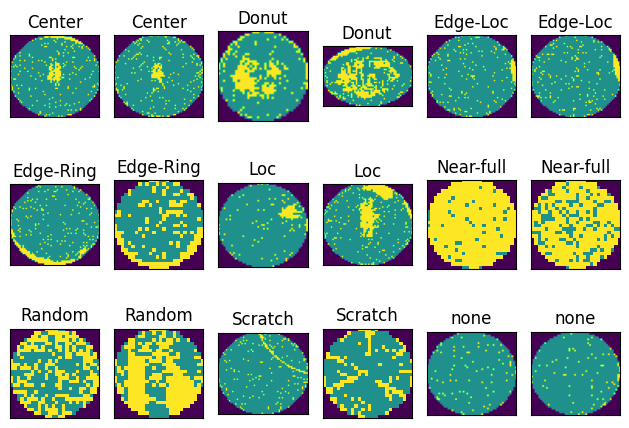

In [ ]:
for i in range(len(failure_types)):
  b = 0
  for j in [0,1]:
    if i != 0:
      b=1
    plt.subplot(3,6,(2*i+1)+j)
    plt.imshow(data['waferMap'][data['failureType'] == failure_types[i]].iloc[j])
    plt.title(failure_types[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

We divide between training and test, putting the test data in a separate list.

In [ ]:
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
training = [0] * 9
test = [0] * 9

for i in range(9):
  training[i] = data[data['failureType'] == classes[i]]
  test[i] = training[i].sample(frac = 0.2)
  training[i] = training[i].drop(test[i].index)

In [ ]:
print(sum(len(i) for i in training))
print(sum(len(i) for i in test))

136196
34050


In [ ]:
training[0].head()

,waferMap,failureType
43,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
543,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1,...",Center
645,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",Center
783,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",Center
2249,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",Center


We have **136196 training data** and **34050 test data**

Before proceeding with augmentation, it is necessary to resize the data to the median shape (53, 52). So, we apply **padding** to the dimensions, so that they become (53, 52) or multiples. Once the images are resized, we increase the data in two stages: in the first we add "hand-made" images to rebalance the anomalous classes, in the second we apply **flipping** and **rotation** to each anomalous image. In particular:

* We do not apply color changes because there are only 3 types of pixels, one of which is for the background.
* We get to 3000 images for the **donut**, **loc**, **near-full**, **random** and **scratch** classes. The idea is to take an image with no defective chips as a template and change the pixels from 1 (chip ok) to 2 (defective chip), based on the class to be increased. For donut, for example, we would have to create "donuts" of anomalous pixels. After that, all anomalous classes will have 3000 instances (except those that already have more than 3000).
* Through a simple neural network, trained on the training data not augmented for 3 epochs, we evaluate the goodness of the hand-crafted augmentation.
* Next, we apply flipping (horizontal and vertical) and 90° rotation (right and left) to each anomalous image.

Eventually the dataset will contain the following images:

* Center: 17115
* Donut: 15000
* Edge-Loc: 20170
* Edge-Ring: 38640
* Loc: 15000
* Near-full: 15000
* Random: 15000
* Scratch: 15000
* None: 116022

A total of 266947 training images.

In [ ]:
classes = failure_types

for i in range(len(training)):
  print(classes[i])
  print(len(training[i]))
  print(len(test[i]))

Center
3423
856
Donut
444
111
Edge-Loc
4034
1008
Edge-Ring
7728
1932
Loc
2811
703
Near-full
119
30
Random
688
172
Scratch
927
232
none
116022
29006


Let's reset the indexes.

In [ ]:
for i in range(len(training)):
  training[i] =  training[i].reset_index(drop = True)
  test[i] =  test[i].reset_index(drop = True)

## Resizing
We define a padding function that adds background pixels to the images, in order to make the dimensions of the new shape multiple of 53 and 52 respectively. So, the visual appearance of the images, when resizing to the shape (53, 52) has not changed.


In [ ]:
def apply_padding(a):
  dim1, dim2 = a.shape
  pad11 = 0
  pad12 = 0
  pad21 = 0
  pad22 = 0
  if(dim1 < 53):
    pad11 = int((53 - dim1)/2)
    pad12 = 53 - dim1 - pad11
  if(dim2 < 52):
    pad21 = int((52 - dim2)/2)
    pad22 = 52 - dim2 - pad21
  if(dim1 > 53):
    pad11 = int((math.ceil(dim1/53) * 53 - dim1)/2)
    pad12 = math.ceil(dim1/53) * 53 - dim1 - pad11
  if(dim2 > 52):
    pad21 = int((math.ceil(dim2/52) * 52 - dim2)/2)
    pad22 = math.ceil(dim2/52) * 52 - dim2 - pad21

  return np.pad(a, ((pad11,pad12),(pad21,pad22)), 'constant', constant_values = ((0,0),(0,0)))

We do padding on the training data.

In [ ]:
training_padded = copy.deepcopy(training)

for i in range(len(training_padded)):
  for j in range(len(training_padded[i]['waferMap'])):
    if (j % 500 == 0):
      print(i, j)
    training_padded[i]['waferMap'][j] = np.array(training_padded[i]['waferMap'][j])
    training_padded[i]['waferMap'][j] = apply_padding(training_padded[i]['waferMap'][j])

0 0
0 500
0 1000
0 1500
0 2000
0 2500
0 3000
1 0
2 0
2 500
2 1000
2 1500
2 2000
2 2500
2 3000
2 3500
2 4000
3 0
3 500
3 1000
3 1500
3 2000
3 2500
3 3000
3 3500
3 4000
3 4500
3 5000
3 5500
3 6000
3 6500
3 7000
3 7500
4 0
4 500
4 1000
4 1500
4 2000
4 2500
5 0
6 0
6 500
7 0
7 500
8 0
8 500
8 1000
8 1500
8 2000
8 2500
8 3000
8 3500
8 4000
8 4500
8 5000
8 5500
8 6000
8 6500
8 7000
8 7500
8 8000
8 8500
8 9000
8 9500
8 10000
8 10500
8 11000
8 11500
8 12000
8 12500
8 13000
8 13500
8 14000
8 14500
8 15000
8 15500
8 16000
8 16500
8 17000
8 17500
8 18000
8 18500
8 19000
8 19500
8 20000
8 20500
8 21000
8 21500
8 22000
8 22500
8 23000
8 23500
8 24000
8 24500
8 25000
8 25500
8 26000
8 26500
8 27000
8 27500
8 28000
8 28500
8 29000
8 29500
8 30000
8 30500
8 31000
8 31500
8 32000
8 32500
8 33000
8 33500
8 34000
8 34500
8 35000
8 35500
8 36000
8 36500
8 37000
8 37500
8 38000
8 38500
8 39000
8 39500
8 40000
8 40500
8 41000
8 41500
8 42000
8 42500
8 43000
8 43500
8 44000
8 44500
8 45000
8 45500
8 46000
8 

We do padding on the test data.

In [ ]:
test_padded = copy.deepcopy(test)

for i in range(len(test_padded)):
  for j in range(len(test_padded[i]['waferMap'])):
    if (j % 500 == 0):
      print(i, j)
    test_padded[i]['waferMap'][j] = np.array(test_padded[i]['waferMap'][j])
    test_padded[i]['waferMap'][j] = apply_padding(test_padded[i]['waferMap'][j])

0 0
0 500
1 0
2 0
2 500
2 1000
3 0
3 500
3 1000
3 1500
4 0
4 500
5 0
6 0
7 0
8 0
8 500
8 1000
8 1500
8 2000
8 2500
8 3000
8 3500
8 4000
8 4500
8 5000
8 5500
8 6000
8 6500
8 7000
8 7500
8 8000
8 8500
8 9000
8 9500
8 10000
8 10500
8 11000
8 11500
8 12000
8 12500
8 13000
8 13500
8 14000
8 14500
8 15000
8 15500
8 16000
8 16500
8 17000
8 17500
8 18000
8 18500
8 19000
8 19500
8 20000
8 20500
8 21000
8 21500
8 22000
8 22500
8 23000
8 23500
8 24000
8 24500
8 25000
8 25500
8 26000
8 26500
8 27000
8 27500
8 28000
8 28500
8 29000


Now, let's resize the padded training data. We use **nearest** as type of interpolation, so that the modified images still have pixels that assume value:

- 0: background;
- 1: chip ok;
- 2: anomalous chip.

In [ ]:
training_padded_resize = copy.deepcopy(training_padded)

resize_model = keras.Sequential(keras.layers.Resizing(53, 52, interpolation = 'nearest'))

for i in range(len(training_padded_resize)):
  for j in range(len(training_padded_resize[i])):
    if(j % 500 == 0):
      print(i, j)
    img = tf.constant([training_padded_resize[i]['waferMap'][j]])
    img = tf.constant(np.moveaxis(img, 0, -1))
    training_padded_resize[i]['waferMap'][j] = (np.array(tf.squeeze(resize_model(img)))).astype(int)

0 0
0 500
0 1000
0 1500
0 2000
0 2500
0 3000
1 0
2 0
2 500
2 1000
2 1500
2 2000
2 2500
2 3000
2 3500
2 4000
3 0
3 500
3 1000
3 1500
3 2000
3 2500
3 3000
3 3500
3 4000
3 4500
3 5000
3 5500
3 6000
3 6500
3 7000
3 7500
4 0
4 500
4 1000
4 1500
4 2000
4 2500
5 0
6 0
6 500
7 0
7 500
8 0
8 500
8 1000
8 1500
8 2000
8 2500
8 3000
8 3500
8 4000
8 4500
8 5000
8 5500
8 6000
8 6500
8 7000
8 7500
8 8000
8 8500
8 9000
8 9500
8 10000
8 10500
8 11000
8 11500
8 12000
8 12500
8 13000
8 13500
8 14000
8 14500
8 15000
8 15500
8 16000
8 16500
8 17000
8 17500
8 18000
8 18500
8 19000
8 19500
8 20000
8 20500
8 21000
8 21500
8 22000
8 22500
8 23000
8 23500
8 24000
8 24500
8 25000
8 25500
8 26000
8 26500
8 27000
8 27500
8 28000
8 28500
8 29000
8 29500
8 30000
8 30500
8 31000
8 31500
8 32000
8 32500
8 33000
8 33500
8 34000
8 34500
8 35000
8 35500
8 36000
8 36500
8 37000
8 37500
8 38000
8 38500
8 39000
8 39500
8 40000
8 40500
8 41000
8 41500
8 42000
8 42500
8 43000
8 43500
8 44000
8 44500
8 45000
8 45500
8 46000
8 

We verify that indeed all the images now have the same shape.

In [ ]:
for i in range(9):
  print(np.unique(list(map(lambda x: x.shape, training_padded_resize[i]['waferMap']))))

[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]


Let's check the images graphically.

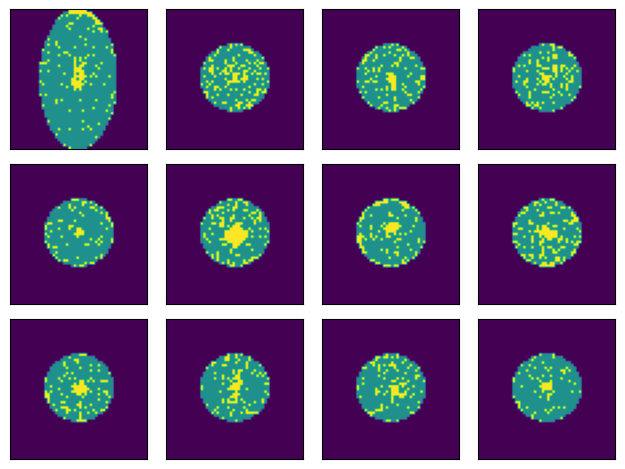

In [ ]:
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.imshow(training_padded_resize[0]['waferMap'][i])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()

We check that, having used **nearest neighborhood** as interpolation method, no images with pixels other than 0, 1 and 2 have been created.

In [ ]:
for i in range(9):
  for j in range(len(training_padded_resize[i]['waferMap'])):
    correct_pixel = sum(
        list(
            map(
                lambda x: list(x).count(0)+list(x).count(1)+list(x).count(2),
                training_padded_resize[i]['waferMap'][j]
                )
            )
        )
    if(correct_pixel != 53 * 52):
      print('Ops', i, j)
      break
print('OK')

OK


Let's save the resized training data in JSON.

In [ ]:
training_preprocessed = pd.concat([training_padded_resize[0],training_padded_resize[1],training_padded_resize[2],
                        training_padded_resize[3],training_padded_resize[4],training_padded_resize[5],
                        training_padded_resize[6],training_padded_resize[7],training_padded_resize[8]])
del training_padded_resize

training_preprocessed['failureType'] = list(map(lambda x: str(x), training_preprocessed['failureType']))

parsed = json.loads(training_preprocessed.to_json(orient = "split"))
del training_preprocessed

with open('/content/WM811K_train_padded_resized_not_augmented.json','w') as f:
    json.dump(parsed, f)
del parsed

In [ ]:
test_padded_resize = copy.deepcopy(test_padded)

resize_model = keras.Sequential(keras.layers.Resizing(53, 52, interpolation = 'nearest'))

for i in range(len(test_padded_resize)):
  for j in range(len(test_padded_resize[i])):
    if(j % 500 == 0):
      print(i, j)
    img = tf.constant([test_padded_resize[i]['waferMap'][j]])
    img = tf.constant(np.moveaxis(img, 0, -1))
    test_padded_resize[i]['waferMap'][j] = (np.array(tf.squeeze(resize_model(img)))).astype(int)

In [ ]:
for i in range(9):
  print(np.unique(list(map(lambda x: x.shape, test_padded_resize[i]['waferMap']))))

In [ ]:
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.imshow(test_padded_resize[0]['waferMap'][i])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()

In [ ]:
for i in range(9):
  for j in range(len(test_padded_resize[i]['waferMap'])):
    correct_pixel = sum(
        list(
            map(
                lambda x: list(x).count(0)+list(x).count(1)+list(x).count(2),
                test_padded_resize[i]['waferMap'][j]
                )
            )
        )
    if(correct_pixel != 53 * 52):
      print('Ops', i, j)
      break
print('OK')

We save the resized test data in JSON.

In [ ]:
test_preprocessed = pd.concat([test_padded_resize[0],test_padded_resize[1],test_padded_resize[2],
                        test_padded_resize[3],test_padded_resize[4],test_padded_resize[5],
                        test_padded_resize[6],test_padded_resize[7],test_padded_resize[8]])
del test_padded_resize

test_preprocessed['failureType'] = list(map(lambda x: str(x), test_preprocessed['failureType']))

parsed = json.loads(test_preprocessed.to_json(orient = "split"))
del test_preprocessed

with open('/content/WM811K_test_padded_resized_not_augmented.json','w') as f:
    json.dump(parsed, f)
del parsed

## Hand-crafted over-sampling

We open the JSON containing the padded and resized training data.

In [9]:
with open('/content/WM811K_train_padded_resized_not_augmented.json', 'r') as f:
  data_pad_resize = json.load(f)

JSONDecodeError: ignored